# import data

In [1]:
from glob import glob
import os
import sys
from tqdm import tqdm

In [2]:
# 读取数据
data_path = r'E:\MIEdata'
fileNames = glob(data_path+'\\p=-1*.txt')

M,ALPHA=[],[]
sr = 1800 + 1
i1 = np.zeros((len(fileNames), sr))
i2 = np.zeros((len(fileNames), sr))
for idx, i in enumerate(fileNames):
    baseName = os.path.basename(i) # 'p=-1,m=0.95,a=973.88.txt'
    _,m,alpha = baseName.split(',')
    alpha = '.'.join(alpha.split('.')[:-1])
    m = m.split('=')[-1]
    alpha=alpha.split('=')[-1]
    M.append(m)
    ALPHA.append(alpha)
    i1[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I1.to_numpy().astype(np.float32)
    i2[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I2.to_numpy().astype(np.float32)

In [2]:
data_path = r'D:\mydata\all_m_alpha'
fileNames = glob(os.path.join(data_path,'*0.txt'))
_idx = np.arange(len(fileNames))
np.random.shuffle(fileNames)
fileNames[:10]
# fileNames=fileNames[:1000]
# fileNames[:10]

['D:\\mydata\\all_m_alpha\\m=0.614000,a=1.250000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.428000,a=73.000000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.312000,a=68.000000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.578000,a=240.500000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.388000,a=26.500000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.542000,a=193.500000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.406000,a=188.000000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.954000,a=182.250000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.482000,a=4.500000.txt',
 'D:\\mydata\\all_m_alpha\\m=0.570000,a=110.250000.txt']

In [4]:
# dump
def dump(sr=None, size=10000):
    
    
    if sr is None: # 从配置文件中获取 sr
        with open(data_path+'\\输入参数文本.txt') as _f:
            _paras = _f.readlines()
            sr = int(_paras[2].split('\t')[0]) + 1
            print('sr=',sr)

    # --------------------------------------------------------------通用begin
    with open(fileNames[0]) as _f:
        simple_size = sys.getsizeof(_f.read())/1024/1024 # Mb

    size = size # 2048:2GB
    num = int(size/simple_size)+1 # 每一次存的大小是 num个读取的文件
    N = int(len(fileNames)//num)  # 存N次大小为num个的文件
    last_num = len(fileNames)%num # 最后一次存的文件是 last_num个读取的文件
    begin=0
    print('size,simple_size,num,N,last_num\n',size,simple_size,num,N,last_num)
    for c_i in tqdm(range(N+1)):
        if c_i==N:
            num = last_num
        last = begin+num
        filename = fileNames[begin:last]
    # --------------------------------------------------------------通用end
        i1 = np.zeros((len(filename), sr))
        i2 = np.zeros((len(filename), sr))
        dop = np.zeros((len(filename), sr))
        M,ALPHA = [], []
        for idx, i in enumerate(filename):
            baseName = os.path.basename(i) 
            m,alpha = baseName.split(',')
            alpha = '.'.join(alpha.split('.')[:-1])
            m = m.split('=')[-1]
            alpha=alpha.split('=')[-1]
            M.append(m)
            ALPHA.append(alpha)

            i1[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I1.to_numpy().astype(np.float32)
            i2[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I2.to_numpy().astype(np.float32)
            dop[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).DOP.to_numpy().astype(np.float32)
            
        M, ALPHA = np.array(M).astype('float32'), np.array(ALPHA).astype('float32')
    # --------------------------------------------------------------- 通用begin
        out_path = r'D:\mydata\out_shuffle'
        np.save(os.path.join(out_path, f'i1_{c_i}.npy'),i1)
        np.save(os.path.join(out_path, f'i2_{c_i}.npy'),i2)
        np.save(os.path.join(out_path, f'dop_{c_i}.npy'),dop)
        np.savez(os.path.join(out_path, f'M_ALPHA_{c_i}.npz'),M=M,ALPHA=ALPHA)
        begin = last
    # --------------------------------------------------------------- 通用end
    return out_path, sr


In [5]:
target_path, sr = dump()

sr= 2048
size,simple_size,num,N,last_num
 10000 0.1297311782836914 77083 4 27668


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:58:46<00:00, 2145.25s/it]


# load data

In [3]:
target_path=r'D:\mydata\out_shuffle'
sr = 2048

In [4]:
# load
def load_data(path):
    fileNames = glob(os.path.join(path,'*'))
    
    name_i1 = [i for i in fileNames if 'i1' in i]
    name_i2 = [i for i in fileNames if 'i2' in i]
    name_dop = [i for i in fileNames if 'dop' in i]
    name_m_alpha = [i for i in fileNames if 'M_ALPHA' in i]
    L = len(name_dop) # 3种文件数目相同
    c = 0
    while True:
        i1 = np.load(name_i1[c%L])
        i2 = np.load(name_i2[c%L])
        dop = np.load(name_dop[c%L])
        res = np.load(name_m_alpha[c%L])
        M, ALPHA = res['M'], res['ALPHA']
        print(i1.shape, i2.shape, M.shape)
        c += 1
        yield i1, i2, dop, M, ALPHA
        

data = load_data(target_path)
i1, i2, dop, M, ALPHA = next(data)

(77083, 2048) (77083, 2048) (77083,)


In [7]:
# M,ALPHA=[],[]
# sr = 2048
# i1 = np.zeros((len(fileNames), sr))
# i2 = np.zeros((len(fileNames), sr))
# dop = np.zeros((len(fileNames), sr))
# for idx, i in enumerate(fileNames):
#     baseName = os.path.basename(i) # 'm=0.95,a=973.88.txt'
#     m,alpha = baseName.split(',')
#     alpha = '.'.join(alpha.split('.')[:-1])
#     m = m.split('=')[-1]
#     alpha=alpha.split('=')[-1]
#     M.append(m)
#     ALPHA.append(alpha)
    
#     i1[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I1.to_numpy().astype(np.float32)
#     i2[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).I2.to_numpy().astype(np.float32)
#     dop[idx] = pd.read_table(i, encoding='gb2312',sep='\t',index_col=None).DOP.to_numpy().astype(np.float32)

In [4]:
i1, i2, dop, M, ALPHA = next(data)
i1.shape, i2.shape, dop.shape, M.shape, ALPHA.shape

(77083, 2048) (77083, 2048) (77083,)


((77083, 2048), (77083, 2048), (77083, 2048), (77083,), (77083,))

(0.332, 33.0)

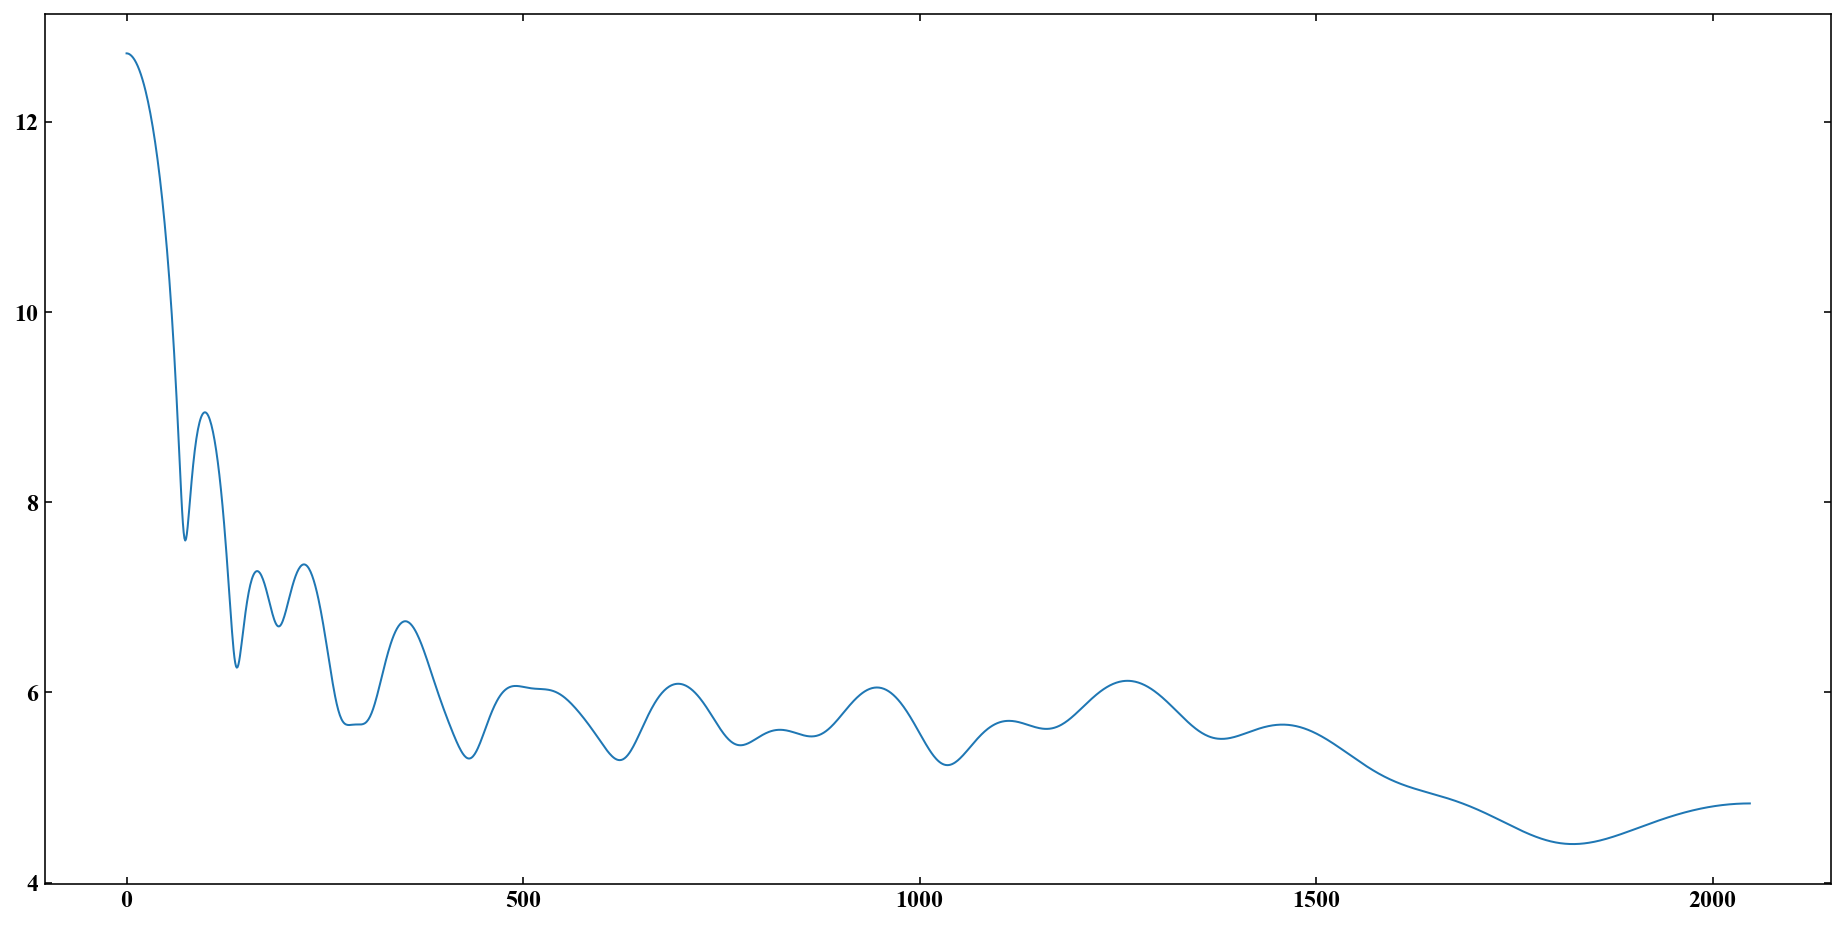

In [5]:
IDX = 20000
plt.figure(figsize=(16,8))
plt.plot(np.log(i1[IDX]))
M[IDX], ALPHA[IDX]

In [11]:
L = len(fileNames)
S = np.arange(L)
np.random.shuffle(S)
S

array([ 61776, 121884,  43504, ..., 202909, 247398,  36099])

# generateData

In [5]:
def generateData(batch,theta1, theta2,i1, i2, dop,M, ALPHA, sr, L=i1.shape[0]):
    S = np.arange(L-1)

    d_the = (sr-1)/180
    th1, th2 = int(theta1*d_the), int(theta2*d_the)
    SR = th2-th1
    while True:
        np.random.shuffle(S)
        series = S[:batch]
        yield SR,\
        i1[series, th1:th2].astype(np.float32)[...,None], \
        i2[series, th1:th2].astype(np.float32)[...,None], \
        dop[series, th1:th2].astype(np.float32)[...,None], \
        np.array(M)[series].astype(np.float32)[...,None], \
        np.array(ALPHA)[series].astype(np.float32)[...,None]
        
theta1, theta2 = 15, 36

data = generateData(15, theta1,theta2,i1,i2,dop,M,ALPHA,sr, i1.shape[0])
SR = next(data)[0]

In [6]:
print(next(data)[0])
print(next(data)[1].shape) # i1
print(next(data)[2].shape) # i2
print(next(data)[3].shape) # dop
print(next(data)[4].shape) # M
print(next(data)[5].shape) # ALPHA

239
(15, 239, 1)
(15, 239, 1)
(15, 239, 1)
(15, 1)
(15, 1)


In [14]:
NEXT = next(data)

(array([0.45], dtype=float32), array([184.75], dtype=float32))

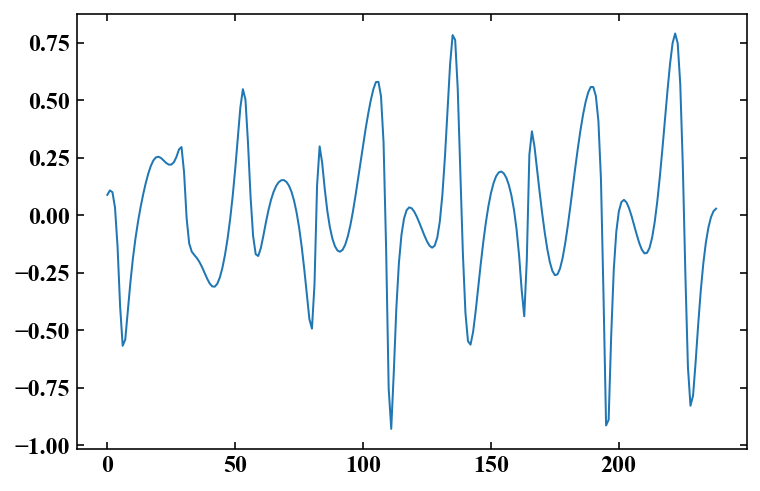

In [105]:

IDX = 11
plt.plot(NEXT[3][IDX])
NEXT[-2][IDX], NEXT[-1][IDX]

# model

In [6]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
# tf.test.is_gpu_available()
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Concatenate, Conv2D,Conv1D,Convolution1D,\
Flatten, BatchNormalization,Input,Dropout
from tensorflow.keras.layers import LeakyReLU, ReLU, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, MAE, KLD, MSLE, MSE

In [7]:
# Model 1
def model1(SR):
    input_x = Input(shape=(SR, 1))
    # x = LayerNormalization()(input_x)
    x = input_x

    x = Conv1D(3, 4, strides=2,padding='same')(x)
    # x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(3, 3, strides=2,padding='same')(x)

    x = ReLU()(x)
    x = Conv1D(3, 3, strides=2,padding='same')(x)

    x = ReLU()(x)
    x = Conv1D(3, 3, strides=2,padding='same')(x)

    x = ReLU()(x)
    x = Conv1D(3, 3, strides=2,padding='same')(x)

    x = ReLU()(x)
    x = Flatten()(x)

    x = Dense(100,'relu')(x)
    rm = Dense(1,'sigmoid')(x)
    alpha = Dense(1,'relu')(x)
    dop = Dense(1, 'tanh')(x)
    model_m = Model(input_x, rm)
    model_alpha = Model(input_x, alpha)
    model_dop = Model(input_x, dop)
    return model_m, model_alpha, model_dop

In [8]:
# Model 2
def model2(SR):
    input_x = Input(shape=(SR, 1))
    # x = LayerNormalization()(input_x)
    
    # convolution part
    cx = input_x
    cx = Conv1D(1, SR//10, strides=2,padding='valid', activation='relu')(cx)
    cx = Conv1D(1, 3, strides=2,padding='valid', activation='relu')(cx)
    cx = Conv1D(1, 3, strides=2,padding='valid', activation='relu')(cx)

    cx = Flatten()(cx)
    
    # full connection part
    fx = input_x
    fx = Flatten()(fx)
    fx = Dense(SR//20,'relu')(fx)

#     x = fx

    x = tf.concat([fx, cx], axis=1)
    print(x.shape)
    rm = Dense(1,'sigmoid')(x)
    alpha = Dense(1, 'relu')(x)
    dop = Dense(1, 'tanh')(x)
    
    model_m = Model(input_x, rm)
    model_alpha = Model(input_x, alpha)
    model_dop = Model(input_x, dop)
    return model_m, model_alpha, model_dop


In [9]:
theta1, theta2 = 15
data = generateData(1, theta1,theta2,i1,i2,dop,M,ALPHA,sr, i1.shape[0])
SR = next(data)[0]

TypeError: cannot unpack non-iterable int object

In [10]:
model_rm, model_alpha, model_dop = model1(SR)
model = model_dop
# model = model_rm
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 239, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 3)            15        
_________________________________________________________________
re_lu (ReLU)                 (None, 120, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 3)             30        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 60, 3)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 3)             30        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 30, 3)             0   

In [11]:
model.compile(loss= MSE,
              optimizer=Adam(learning_rate=2e-3, beta_1=0.5)
#               optimizer=SGD()
             )

In [13]:
batch = 500
DATA = load_data(target_path)
Big_loop = 0

In [15]:
while Big_loop < 1:

    i1,i2,dop,M,ALPHA = next(DATA)
    Big_loop += 1
    data = generateData(batch,theta1,theta2,i1,i2,dop,M,ALPHA,sr, i1.shape[0])
    
    # 使用集成度较低的 Model.train_on_batch方法，自行设定batch数据　和　epochs
    for step in range(1000):
        train_data = next(data)
    #     cost = model.train_on_batch(train_data[1], train_data[-2]) # i1
    #     cost = model.train_on_batch(train_data[2], train_data[-2]) # i2
        cost = model.train_on_batch(train_data[3], train_data[-2]) # dop

        if step%100==0:
            print(f'loss: {cost}')

In [33]:
def test_simple(theta1, theta2, alpha, rm, noise=False):
    test_i1, test_i2, test_dop = gen(alpha = alpha, rm = rm, N_ta = sr-1) # 
    
    d_the = (sr-1)/180
    th1, th2 = int(theta1*d_the), int(theta2*d_the)
    SR = th2-th1
    test_i1, test_i2, test_dop = test_i1[th1:th2], test_i2[th1:th2], test_dop[th1:th2]
    
    if noise:
        noise = np.random.rand(SR, 1) * 0.05
        noise_dop = (np.random.rand(SR, 1)-0.5) * 0.05
        test_i1, test_i2, = test_i1+noise, test_i2+noise
        test_dop = test_dop + noise_dop
    return test_i1, test_i2, test_dop 

def test_batch():
    RM = [0.32, 0.42, 0.52, 0.62, 0.72, 0.82, 0.92]
    ALPHA=[1.2, 10.2, 20.2, 50.2, 100.2, 150.2, 200.2, 250.2]
    RES = np.zeros((len(RM),len(ALPHA)))
    for ir, rm in enumerate(RM):
        for ia, alpha in enumerate(ALPHA):
            test_dop = test_simple(theta1, theta2,alpha,rm, noise=0)[2]
            pred_rm = model.predict(test_dop[None,])
            
            RES[ir][ia] = pred_rm
    
    loss_rm = np.mean(RES, axis=1)
    std_rm = np.std(RES, axis=1)
    return std_rm, loss_rm
    


In [36]:
test_i1, test_i2, test_dop = test_simple(theta1, theta2,alpha=20,rm=0.77, noise=0)
# pred_data = model.predict(np.log(test_i2[None,]))
pred_data = model.predict(test_dop[None,])
print(pred_data)

[[0.7720144]]


In [38]:
std_rm, loss_rm = test_batch()
print(std_rm,'\n', loss_rm)

[0.12691866 0.09356752 0.06583603 0.0335801  0.01328056 0.03027053
 0.06351726] 
 [0.36591952 0.45955423 0.53676327 0.62735608 0.7217669  0.80397666
 0.88576923]


In [35]:
def test_generateData(alpha,rm,im =0.0,N_ta = 2**13-1):
    origin_path = os.getcwd()
#     os.chdir(r"C:\Users\beidongjiedeguang\Desktop\测试文件夹")
    os.chdir(r"C:\Users\Administrator\OneDrive\Mie测试文件夹")
    exeName = "Mie_Calculation.exe"
    txtName = '输入参数文本.txt'

    Ta_min, Ta_max = 0,180
    with open(txtName,'w') as f1:
        f1.write('{}\n{:.3f}\t{:.3f}\n{}\t{:.2f}\t{:.2f}'
                .format(alpha,rm,im,N_ta,Ta_min,Ta_max))

    os.system(exeName)
    dataName = "散射光强角分布.txt"
    # 没想到c写出来的不是utf-8编码的，所以这里encoding='gbk'，后面这个delimiter随便要不要
    data = pd.read_csv(dataName,sep ='\t',engine='python',encoding='gbk',delimiter='\s+')
    os.remove(dataName)
    os.chdir(origin_path)
    return data

def gen(alpha = 900, rm = 1.7, im= 0.0, N_ta = 2**13-1):
    data = test_generateData(alpha,rm,im, N_ta = N_ta)
    theta = data['散射角'].to_numpy()
    i1, i2, DOP = data['I1'].to_numpy(), data['I2'].to_numpy(), data['可视度'].to_numpy()
    return i1[...,None], i2[...,None], DOP[...,None]